### Table of Contents

[*Problem Statement*](#Problem)

[*Importing Libraries*](#Libraries)

[*Loading the source data*](#DataInput)

[*Data PreProcessing*](#Preproc)

[*Using Word Embeddings to convert sequences to vectors*](#seq2vec)

[*K-means Clustering*](#Clustering)

[*Cluster Distribution*](#Visualisation)



<a name="Problem">
Problem Statement
</a>

##### Using a Topic Modeling technique (NLP) to categorise the event sequences into clusters. Each sequence is represented as a vector.

Analogies for the application of the word embedding technique:

Event--> Word

Sequences--> Sentences

<a name="Libraries">
Importing libraries
</a>

In [2]:
import numpy as np
import pandas as pd
import itertools
import time
import operator
from sklearn.cluster import KMeans
import sklearn
import pylab as pl
import matplotlib.pyplot as plt
from collections import Counter
import random 
from gensim.models import Word2Vec
  
from nltk.cluster import KMeansClusterer
import nltk
import numpy as np 
  
from sklearn import cluster
from sklearn import metrics

C:\ProgramData\Annaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used


<a name="DataInput">
Loading the source file (csv)
</a>

In [3]:
events=pd.read_csv('events_clean.csv')

In [4]:
len(events)

39991

In [5]:
events.head(3)

,Unnamed: 0,newid,event_code_new
0,0,470.736995,SS.fswsSpswSpswS.pswSpswSpswSpsw.pS.cfsws.Sp.p...
1,1,497.857109,lbsSsSsSsSsSsSsS.psSsSsS.sSsSpSpS.SlspSpspSpsp...
2,2,538.770109,.SlS.S.S.S.sb


In [6]:
events.newid.nunique()

39968

<a name="Preproc">
Data PreProcessing
</a>

In [7]:
b= events['event_code_new']
til = []
for i in range(len(events.newid)):
#for i in range(100):
    t = str(b[i])
    til.append(t)
print(len(til))

39991


In [8]:
# to remove consecutive repeating characters 
tila=[]
for i in range(len(til)):
    b=''.join(i for i, _ in itertools.groupby(til[i]))
    tila.append(b)
print(len(tila))
print(tila)


39991
['S.fswsSpswSpswS.pswSpswSpswSpsw.pS.cfsws.Sp.pS.spsSsS.S.swSpsws.pS.cS.S.pswsS.pswsp.wsSp.swsp.p.', 'lbsSsSsSsSsSsSsS.psSsSsS.sSsSpSpS.SlspSpspSpspS.p.sb.bSlSlSlSlsS.p.blSs', '.SlS.S.S.S.sb', 'S.Slfn.nbnfc.c.cn.bcb.bSfSfSfSfSewSfncnb.', 'lb.s.s.n.b.bt.f.fc.ncbibib.bn.nt.fb.b.b.lc.i.sp.psp.sp.psp.psp.pc.c.i.b.cb.i.t.t.t.t.t.t.t.i.nbvb.t.tfb.b.', 'eses.b.be', 'f.f.f.f.f.s.f.f.sf.blblcefn.', 'spfswsbsp.b.wewspswsp.p.wsp.', '.p.peSesesps', 'spsps', '.nes.f.pepscnb.cn', 'p.pbSlSs.psp.pf.', '.bfsfb.b.ib.bvb.b.bib.nbfb.', 'esp.eSlepSp', 'f.f.p.spsf.f.f.s.f.b.bib.p.bvb.b.bib.b.b.f.p.n.b.b.b.b.b.p.p.swspwsp.wsp.pws.f.', '.bswspws.p.', 'spS.p.p.p', 'nbf.s.fsf.fsfsf.i.n.bf.p.f.f.n.cf.s.s.s.f.nbf.sp.psp.psp.psbspspspsbsSsSsSsSsS.SsSsSsSsSs.', 'bfbibfbn.', 'pS.pS.bS.p.p.p.pSsSsSsSpSsSsSsS.SlSlbp', 'fspfpfpfspspspspspsp.spfp.psfesfs.fpc.b.ps.esb.b.', 'fb.b.sSsSp.fs.fs.fb.b.bfs.', 'pbfpf.fbfn.i.b.bn.', 'slblf.sp.p.spsp', 'S.b.S.l', '.eswsb', 'wspswspswsp.pswpswswsp.pswsp.psp.psws.pscfslspspsps

In [9]:
n_tila=[s.replace('.', '.') for s in tila]
print(n_tila[:5])
#info = (data[:75] + '..') if len(data) > 75 else data

['S.fswsSpswSpswS.pswSpswSpswSpsw.pS.cfsws.Sp.pS.spsSsS.S.swSpsws.pS.cS.S.pswsS.pswsp.wsSp.swsp.p.', 'lbsSsSsSsSsSsSsS.psSsSsS.sSsSpSpS.SlspSpspSpspS.p.sb.bSlSlSlSlsS.p.blSs', '.SlS.S.S.S.sb', 'S.Slfn.nbnfc.c.cn.bcb.bSfSfSfSfSewSfncnb.', 'lb.s.s.n.b.bt.f.fc.ncbibib.bn.nt.fb.b.b.lc.i.sp.psp.sp.psp.psp.pc.c.i.b.cb.i.t.t.t.t.t.t.t.i.nbvb.t.tfb.b.']


In [10]:
temp= list(tila)
lengths=[len(x) for x in temp]
l=[]
for i in temp:
    if len(i)>5:
        l.append([k for k in i])


In [11]:
print("Before filtering: ",len(temp))
print("After removing string lengths less than 5: ", len(l))

Before filtering:  39991
After removing string lengths less than 5:  37994


<a name="seq2vec">
Converting Sequences to vectors
</a>

In [12]:
start = time.time()
# training data

random.seed(1234)

####Using only 10000 random for faster computation
sentences = random.sample(l,10000)
model = Word2Vec(sentences, min_count=2)
 
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
     
    return np.asarray(sent_vec) / numw
  
X=[]
for sentence in sentences:
    X.append(sent_vectorizer(sentence, model))   

print (model[model.wv.vocab])

C:\ProgramData\Annaconda3\lib\site-packages\gensim\models\word2vec.py:906: UserWarning: C extension not loaded for Word2Vec, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded for Word2Vec, training will be slow. "


[[ 2.3335931e+00  2.0439792e+00  4.8509866e-01 ...  9.2946762e-01
  -1.6643675e-01  8.4570408e-01]
 [ 1.6578763e+00  1.9014518e+00  3.9961660e-01 ...  1.2695438e+00
   2.7380217e-02  1.3504899e+00]
 [ 1.9941484e+00  8.0894041e-01  1.2010065e+00 ...  1.0815326e+00
   2.1909324e-02  7.7054137e-01]
 ...
 [ 2.6911130e+00  2.2035298e+00  5.8475268e-01 ...  1.7912740e+00
  -7.6038396e-01  1.5487102e+00]
 [ 1.3967696e+00  1.3059227e+00 -3.6289358e-01 ...  9.6840030e-01
   1.4421287e-01  1.1011506e+00]
 [-3.8190722e-02 -7.4430317e-02 -1.1839624e-02 ... -1.5118081e-02
   1.6143698e-03 -5.8293766e-03]]


<a name="clustering">
Using Kmeans to clusters the sequence vectors
</a>

Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-6889.16342346029
Silhouette_score: 
0.25374982


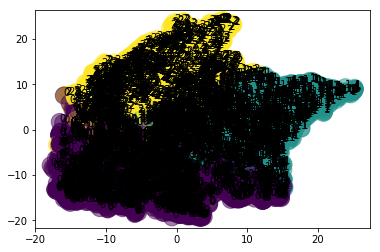

1135.0028722286224


In [13]:
 NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
##print (assigned_clusters)
   
# for index, sentence in enumerate(sentences):    
#     print (str(assigned_clusters[index]) + ":" + str(sentence))
 
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
  
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
  
# print ("Cluster id labels for inputted data")
# ##print (labels)
# print ("Centroids data")
# print (centroids)
  
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
  
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
  
print ("Silhouette_score: ")
print (silhouette_score)
 
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE
 
model = TSNE(n_components=3, random_state=0)
np.set_printoptions(suppress=True)
 
Y=model.fit_transform(X)
 
plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=290,alpha=.5) 
 
for j in range(len(sentences)):    
    plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
   #print ("%s" % (assigned_clusters[j]))
 
plt.show()

print(time.time()-start)


<a name="Visualisation">
Cluster Distribution
</a>

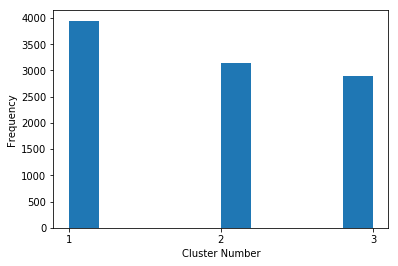

In [57]:
##plt.hist(assigned_clusters,alpha=0.5)
import seaborn as sns

##clusters=pd.DataFrame.from_records(assigned_clusters,columns=['Clusters'])
plot=plt.hist([ int(x)+1 for x in assigned_clusters])
plt.xticks(range(1,4))
plt.xlabel("Cluster Number")
plt.ylabel("Frequency")
plt.show()




In [29]:
type(assigned_clusters)

list

#### Trying Doc2vec (Additional)

In [ ]:
# from gensim.test.utils import common_texts
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument
 

# sentences=l
# documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(sentences)]
 
# print (documents[:1])

 
# model = Doc2Vec(documents, size=5, window=2, min_count=1, workers=4)
# #Persist a model to disk:
 
# from gensim.test.utils import get_tmpfile
# fname = get_tmpfile("my_doc2vec_model")
 
# print (fname)
# #output: C:\Users\userABC\AppData\Local\Temp\my_doc2vec_model
 
# #load model from saved file
# model.save(fname)
# model = Doc2Vec.load(fname)  
# # you can continue training with the loaded model!
# #If you’re finished training a model (=no more updates, only querying, reduce memory usage), you can do:
 
# model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
 
# #Infer vector for a new document:
# #Here our text paragraph just 2 words
# vector = model.infer_vector(["system", "response"])
# print (vector)

In [30]:
# start = time.time()
# #inference hyper-parameters
# start_alpha=0.01
# infer_epoch=1000

# X=[]
# for d in sentences:
      
#     X.append( model.infer_vector(d, alpha=start_alpha, steps=infer_epoch) )
    
# k=3


# from sklearn.cluster import Birch
 
# brc = Birch(branching_factor=50, n_clusters=k, threshold=0.1, compute_labels=True)
# brc.fit(X)
 
# clusters = brc.predict(X)
 
# labels = brc.labels_
 
# print ("Clusters: ")
# print (clusters)
 
# silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
# print ("Silhouette_score: ")
# print (silhouette_score)

# print(time.time()-start)

Clusters: 
[0 1 2 ... 0 0 0]
Silhouette_score: 
0.12817226
